In [131]:
import os
from typing import Annotated, Sequence, TypedDict
from dotenv import load_dotenv
from langgraph.graph import StateGraph,START,END
from IPython.display import display,Image
from langchain_groq.chat_models import ChatGroq
from langchain_core.messages import BaseMessage,ToolMessage, AIMessage,HumanMessage,FunctionMessage,SystemMessage
from langgraph.prebuilt import ToolNode
from langchain_core.tools import tool
from langgraph.graph.message import add_messages

load_dotenv()

True

In [132]:
llm = ChatGroq(model="qwen-qwq-32b")

In [133]:
#add message is a reducer function
class AgentState(TypedDict):
    messages:Annotated[Sequence[BaseMessage],add_messages]


In [157]:
@tool
def add(a:int,b:int) -> int:
    """
    add two given numbers
    Args
    a: first number
    b: second numnber
    """
    return a + b

@tool
def multiply(a:int,b:int) -> int:
    """
    multiply given two numbers
    Args
    a: first number
    b: second numnber
    """
    return a * b

In [158]:
tools = [add,multiply]

In [159]:
llm_with_tools = llm.bind_tools(tools=tools,parallel_tool_calls=False)

In [160]:
tool_node = ToolNode(tools=tools)

In [161]:
def chat_bot(state:AgentState) -> AgentState:
    system_prompt = SystemMessage(content="you are an AI assistent, answer my question on best of your knowledge")
    response = llm_with_tools.invoke([system_prompt] + state['messages'])
    return {"messages": [response]}

In [162]:
def should_continue(state:AgentState) -> AgentState:
    message = state['messages']
    last_message = message[-1]
    print(f"last_message :: {last_message}")
    if not last_message.tool_calls:
        return "end"
    else:
        return "continue"

In [163]:
builder = StateGraph(AgentState)

In [164]:
builder.add_node("chatbot",chat_bot)
builder.add_node("tools",tool_node)
builder.add_conditional_edges("chatbot",
                              should_continue,
                              {
                                 "continue":"tools",
                                 "end":END 
                              }
                              )
#builder.add_node("additon",tool_nodes)
builder.add_edge("tools","chatbot")
builder.set_entry_point("chatbot")
#builder.add_edge("addition",END)

In [165]:
graph = builder.compile()

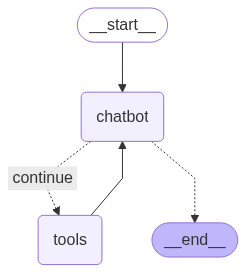

In [143]:
Image(graph.get_graph().draw_mermaid_png())

In [169]:
response = graph.invoke({"messages":[("user","Add 40 and 12")]})


last_message :: content='' additional_kwargs={'tool_calls': [{'id': 'call_k3k7', 'function': {'arguments': '{"a":40,"b":12}', 'name': 'add'}, 'type': 'function'}]} response_metadata={'token_usage': {'completion_tokens': 107, 'prompt_tokens': 274, 'total_tokens': 381, 'completion_time': 0.243228389, 'prompt_time': 0.020338003, 'queue_time': 2.134436203, 'total_time': 0.263566392}, 'model_name': 'qwen-qwq-32b', 'system_fingerprint': 'fp_28178d7ff6', 'finish_reason': 'tool_calls', 'logprobs': None} id='run-4e6f4630-9646-4ee4-ac47-eac1747d2896-0' tool_calls=[{'name': 'add', 'args': {'a': 40, 'b': 12}, 'id': 'call_k3k7', 'type': 'tool_call'}] usage_metadata={'input_tokens': 274, 'output_tokens': 107, 'total_tokens': 381}
last_message :: content='The sum of 40 and 12 is **52**.' additional_kwargs={} response_metadata={'token_usage': {'completion_tokens': 107, 'prompt_tokens': 322, 'total_tokens': 429, 'completion_time': 0.264123379, 'prompt_time': 0.024963066, 'queue_time': 0.261808903000000

In [170]:
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 40 and 12
================================== Ai Message ==================================
Tool Calls:
  add (call_k3k7)
 Call ID: call_k3k7
  Args:
    a: 40
    b: 12
================================= Tool Message =================================
Name: add

52
================================== Ai Message ==================================

The sum of 40 and 12 is **52**.


In [109]:
def print_stream(stream):
    for s in stream:
        message = s["messages"][-1]
        if isinstance(message, tuple):
            print(message)
        else:
            message.pretty_print()

inputs = {"messages": [("user", "Add 40 + 12 .")]}
print_stream(graph.stream(inputs, stream_mode="values"))

================================ Human Message =================================

Add 40 + 12 .
================================== Ai Message ==================================
Tool Calls:
  add (call_dj9d)
 Call ID: call_dj9d
  Args:
    a: 40
    b: 12
